# Predicting Credit defaulters using Deep Learning

In this blog, we will be performing binary classification by predicting a credit defaulter using age, sex, marital status, education, history of past payment, amount of bill statement and past payment. This kind of model is useful for banks and credit card companies to determine if a person is likely to default on a bill/loan. We will be using feed forward neural networks here. The dataset for this problem is taken from: https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset

We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model


In [1]:
#!conda install numpy pytorch torchvision cpuonly -c pytorch -y
#!pip install matplotlib --upgrade --quiet
!pip install jovian --upgrade --quiet

In [2]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

<IPython.core.display.Javascript object>

In [3]:
project_name='default-credit-card' # will be used by jovian.commit

## Step 1: Download and explore the data

This dataset is available in Kaggle so we just add it using 'Add Data' option.

In [4]:
DATA_FILENAME = "../input/default-of-credit-card-clients-dataset/UCI_Credit_Card.csv"

> To load this CSV type dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [5]:
dataframe = pd.read_csv(DATA_FILENAME)
dataframe.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


**Attribute Information:**

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:

X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.'LIMIT_BAL'

X2: Gender (1 = male; 2 = female). 'SEX'

X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 'EDUCATION'

X4: Marital status (1 = married; 2 = single; 3 = others). 'MARRIAGE'

X5: Age (year).

X6 - X11: History of past payment.

The past monthly payment records (from April to September, 2005) as follows:

X6 = the repayment status in September, 2005;

X7 = the repayment status in August, 2005; X8 = the repayment status in July, 2005; X9 = the repayment status in June, 2005; X10 = the repayment status in May, 2005;

X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.

X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.

X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.

In [6]:
input_cols=['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

The above are column titles for the input variables. 

In [7]:
output_cols='default.payment.next.month'
# This is the response/target variable we are trying to predict

In [8]:
categorical_cols=['SEX', 'EDUCATION', 'MARRIAGE',  'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
cont_cols=['LIMIT_BAL','BILL_AMT1', 'BILL_AMT2','AGE',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

## Exploratory Analysis

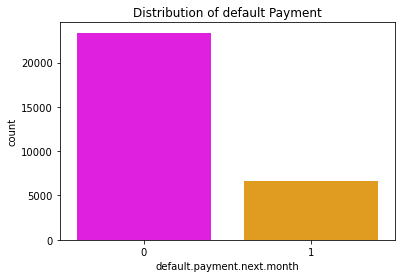

In [9]:
import seaborn as sns
plt.title("Distribution of default Payment")
sns.countplot(x='default.payment.next.month',data=dataframe,palette=['magenta','orange']);

As one would expect majority of the customers are non-defaulters or pay their debts on time.

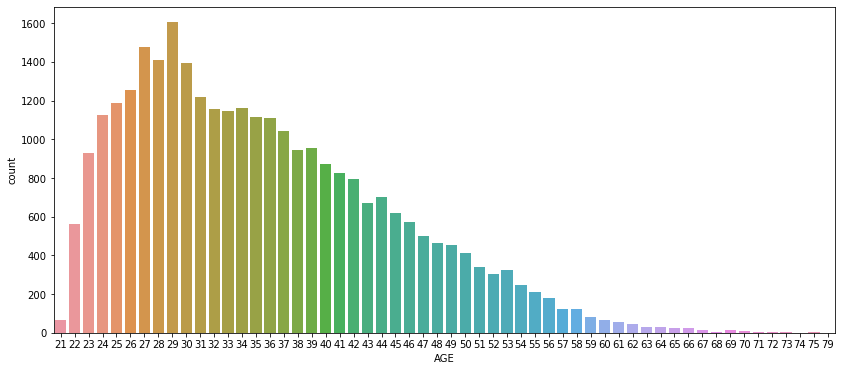

In [10]:
from matplotlib import pyplot
a4_dims = (14, 6)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.countplot(dataframe['AGE'],ax=ax)

Looking at the distribution of age, a lot of them are in 27-30 range.

In [11]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/mukundan-sankar14/default-credit-card


<IPython.core.display.Javascript object>

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [12]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

In [13]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[2.0000e+04, 1.0000e+00, 2.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.2000e+05, 1.0000e+00, 2.0000e+00, ..., 1.0000e+03, 0.0000e+00,
         2.0000e+03],
        [9.0000e+04, 1.0000e+00, 2.0000e+00, ..., 1.0000e+03, 1.0000e+03,
         5.0000e+03],
        ...,
        [3.0000e+04, 0.0000e+00, 2.0000e+00, ..., 4.2000e+03, 2.0000e+03,
         3.1000e+03],
        [8.0000e+04, 0.0000e+00, 3.0000e+00, ..., 1.9260e+03, 5.2964e+04,
         1.8040e+03],
        [5.0000e+04, 0.0000e+00, 2.0000e+00, ..., 1.0000e+03, 1.0000e+03,
         1.0000e+03]]),
 array([1, 1, 0, ..., 1, 1, 1]))

**Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [14]:
import numpy as np
inputs = torch.from_numpy(np.array(inputs_array,dtype=np.float32))
targets = torch.from_numpy(np.array(targets_array,dtype=np.float32))

In [15]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [16]:
dataset = TensorDataset(inputs, targets)

In [17]:
val_percent = 0.2 
num_rows=len(dataframe)
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size
train_ds, val_ds = random_split(dataset,[train_size,val_size]) # Use the random_split function to split dataset into 2 parts of the desired length

Finally, we can create data loaders for training & validation.

**Picking a batch size for the data loader.**

In [18]:
batch_size = 16

In [19]:
input_size = len(input_cols)
num_classes=2

In [20]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)
#or input_s,labels in train_loader:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break    

inputs: tensor([[ 1.0000e+05,  1.0000e+00,  2.0000e+00,  2.0000e+00,  2.4000e+01,
          4.0000e+00,  2.0000e+00,  2.0000e+00,  2.0000e+00,  2.0000e+00,
          2.0000e+00,  1.7765e+05,  9.4299e+04,  9.6389e+04,  9.7571e+04,
          8.6202e+04,  9.2282e+04,  7.9000e+03,  4.5000e+03,  3.8000e+03,
          3.5000e+03,  7.5000e+03,  3.5000e+03],
        [ 2.4000e+05,  1.0000e+00,  2.0000e+00,  1.0000e+00,  3.8000e+01,
          2.0000e+00,  2.0000e+00,  2.0000e+00,  2.0000e+00,  2.0000e+00,
          2.0000e+00,  2.3199e+05,  2.0271e+05,  1.9971e+05,  2.0377e+05,
          2.0802e+05,  2.2011e+05,  1.0028e+04,  7.7110e+03,  7.7670e+03,
          8.0150e+03,  1.5829e+04,  9.0000e+03],
        [ 2.0000e+05,  1.0000e+00,  2.0000e+00,  2.0000e+00,  3.5000e+01,
          2.0000e+00,  2.0000e+00,  2.0000e+00,  2.0000e+00,  2.0000e+00,
          2.0000e+00,  7.2450e+04,  5.2795e+04,  4.1861e+04,  3.4531e+04,
          1.7940e+03, -3.4500e+02,  5.5560e+03,  1.0000e+03,  2.0000e+03,
      

Let's save our work by committing to Jovian.

In [21]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/mukundan-sankar14/default-credit-card


<IPython.core.display.Javascript object>

In [22]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

## Using Sigmoid function

In [23]:
class CreditModel(nn.Module):
    def __init__(self):
        super().__init__()
        #hidden layer 1
        self.linear1 = nn.Linear(input_size, 16)
        #hidden layer 2
        self.linear2 = nn.Linear(16,8)
        #hidden layer 3
        self.linear3 = nn.Linear(8,4)
        # output layer
        self.linear_out = nn.Linear(4,num_classes)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm1d(16)
        self.batchnorm2 = nn.BatchNorm1d(8)
        self.batchnorm3 = nn.BatchNorm1d(4)
        
    def forward(self, inputs):
        x = self.sigmoid(self.linear1(inputs))
        x = self.batchnorm1(x)
        x = self.sigmoid(self.linear2(x))
        x = self.batchnorm2(x)
        x = self.sigmoid(self.linear3(x))
        x = self.batchnorm3(x)
        x = self.dropout(x)
        x = self.linear_out(x)
        
        return x

    
    def training_step(self, batch):
        images, labels = batch 
        labels=labels.type(torch.long)
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        labels=labels.type(torch.long)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = CreditModel()
model

CreditModel(
  (linear1): Linear(in_features=23, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=8, bias=True)
  (linear3): Linear(in_features=8, out_features=4, bias=True)
  (linear_out): Linear(in_features=4, out_features=2, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
  (batchnorm1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [24]:
class CreditModel(nn.Module):
    def __init__(self):
        super().__init__()
        #hidden layer 1
        self.linear1 = nn.Linear(input_size, 16)
        #hidden layer 2
        self.linear2 = nn.Linear(16,8)
        #hidden layer 3
        self.linear3 = nn.Linear(8,4)
        # output layer
        self.linear_out = nn.Linear(4,num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, inputs):
        x = self.sigmoid(self.linear1(inputs))
        x = self.sigmoid(self.linear2(x))
        x = self.sigmoid(self.linear3(x))
        x = self.linear_out(x)
        
        return x

    
    def training_step(self, batch):
        images, labels = batch 
        labels=labels.type(torch.long)
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        labels=labels.type(torch.long)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch_sigmoid [{}], val_loss_sigmoid: {:.4f}, val_acc_sigmoid: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = CreditModel()
model

CreditModel(
  (linear1): Linear(in_features=23, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=8, bias=True)
  (linear3): Linear(in_features=8, out_features=4, bias=True)
  (linear_out): Linear(in_features=4, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)

In [25]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            images, labels = batch
            out = model(images)
            labels=labels.type(torch.long)
            #             loss = model.training_step(batch)
            loss = F.cross_entropy(out, labels)   #y_batch.unsqueeze(1)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [26]:
result = evaluate(model,val_loader) # Use the the evaluate function
print(result)

{'val_loss': 0.7018009424209595, 'val_acc': 0.22233332693576813}


In [27]:
epochs = 10
lr = 1e-3
history = fit(epochs, lr, model, train_loader, val_loader)

Epoch_sigmoid [0], val_loss_sigmoid: 0.5462, val_acc_sigmoid: 0.7777
Epoch_sigmoid [1], val_loss_sigmoid: 0.5317, val_acc_sigmoid: 0.7777
Epoch_sigmoid [2], val_loss_sigmoid: 0.5301, val_acc_sigmoid: 0.7777
Epoch_sigmoid [3], val_loss_sigmoid: 0.5298, val_acc_sigmoid: 0.7777
Epoch_sigmoid [4], val_loss_sigmoid: 0.5298, val_acc_sigmoid: 0.7777
Epoch_sigmoid [5], val_loss_sigmoid: 0.5298, val_acc_sigmoid: 0.7777
Epoch_sigmoid [6], val_loss_sigmoid: 0.5298, val_acc_sigmoid: 0.7777
Epoch_sigmoid [7], val_loss_sigmoid: 0.5298, val_acc_sigmoid: 0.7777
Epoch_sigmoid [8], val_loss_sigmoid: 0.5298, val_acc_sigmoid: 0.7777
Epoch_sigmoid [9], val_loss_sigmoid: 0.5298, val_acc_sigmoid: 0.7777


## Using Softmax function

In [28]:
class CreditModel(nn.Module):
    def __init__(self):
        super().__init__()
        #hidden layer 1
        self.linear1 = nn.Linear(input_size, 256)
        #hidden layer 2
        self.linear2 = nn.Linear(256,128)
        #hidden layer 3
        self.linear3 = nn.Linear(128,32)
        #hidden layer 4
        self.linear4 = nn.Linear(32,8)
        
        self.softmax = nn.Softmax()
        self.dropout = nn.Dropout(p=0.5)
        #.batchnorm1 = nn.BatchNorm1d(256)
        #self.batchnorm2 = nn.BatchNorm1d(128)
        #self.batchnorm3 = nn.BatchNorm1d(32)
        #self.batchnorm4 = nn.BatchNorm1d(8)
        # output layer
        self.linear_out = nn.Linear(8,num_classes)
        
    def forward(self, inputs):
        x = self.softmax(self.linear1(inputs))
        #x = self.batchnorm1(x)
        x = self.softmax(self.linear2(x))
        #x = self.batchnorm2(x)
        x = self.softmax(self.linear3(x))
        #x = self.batchnorm3(x)
        x = self.softmax(self.linear4(x))
        #x = self.batchnorm4(x)
        
        x = self.dropout(x)
        x = self.linear_out(x)
        
        return x

    
    def training_step(self, batch):
        images, labels = batch 
        labels=labels.type(torch.long)
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        labels=labels.type(torch.long)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch_softmax [{}], val_loss_softmax: {:.4f}, val_acc_softmax: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model_softmax = CreditModel()
model_softmax

CreditModel(
  (linear1): Linear(in_features=23, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=32, bias=True)
  (linear4): Linear(in_features=32, out_features=8, bias=True)
  (softmax): Softmax(dim=None)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_out): Linear(in_features=8, out_features=2, bias=True)
)

In [29]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            images, labels = batch
            out = model(images)
            labels=labels.type(torch.long)
            #             loss = model.training_step(batch)
            loss = F.cross_entropy(out, labels)   #y_batch.unsqueeze(1)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [30]:
result = evaluate(model_softmax,val_loader) # Use the the evaluate function
print(result)
epochs = 10
lr = 1e-3
history = fit(epochs, lr, model_softmax, train_loader, val_loader)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


{'val_loss': 0.6754872798919678, 'val_acc': 0.6493333578109741}
Epoch_softmax [0], val_loss_softmax: 0.5633, val_acc_softmax: 0.7777
Epoch_softmax [1], val_loss_softmax: 0.5393, val_acc_softmax: 0.7777
Epoch_softmax [2], val_loss_softmax: 0.5337, val_acc_softmax: 0.7777
Epoch_softmax [3], val_loss_softmax: 0.5313, val_acc_softmax: 0.7777
Epoch_softmax [4], val_loss_softmax: 0.5304, val_acc_softmax: 0.7777
Epoch_softmax [5], val_loss_softmax: 0.5302, val_acc_softmax: 0.7777
Epoch_softmax [6], val_loss_softmax: 0.5304, val_acc_softmax: 0.7777
Epoch_softmax [7], val_loss_softmax: 0.5304, val_acc_softmax: 0.7777
Epoch_softmax [8], val_loss_softmax: 0.5298, val_acc_softmax: 0.7777
Epoch_softmax [9], val_loss_softmax: 0.5302, val_acc_softmax: 0.7777


val_loss = 0.5014 #with 10 epochs and 1e-3 learning rate for ReLU sounds better than sigmoid. 
However, ReLU took more time than sigmoid so we will use Sigmoid since the difference in accuracy is only slight.

Let's log the final validation loss to Jovian and commit the notebook

In [35]:
val_loss=0.5298
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


In [36]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/mukundan-sankar14/default-credit-card


<IPython.core.display.Javascript object>

Now scroll back up, re-initialize the model, and try different set of values for batch size, number of epochs, learning rate etc. Commit each experiment and use the "Compare" and "View Diff" options on Jovian to compare the different results.

## Step 5: Make predictions using the trained model

**Q: Complete the following function definition to make predictions on a single input**

In [37]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)             
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [40]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([1.0000e+05, 0.0000e+00, 2.0000e+00, 1.0000e+00, 5.0000e+01, 2.0000e+00,
        2.0000e+00, 2.0000e+00, 2.0000e+00, 2.0000e+00, 2.0000e+00, 9.5549e+04,
        9.8909e+04, 8.1181e+04, 4.8194e+04, 4.0692e+04, 1.8110e+04, 5.0250e+03,
        2.9390e+03, 1.8263e+04, 1.5761e+04, 4.1800e+02, 5.8300e+02])
Target: tensor(0.)
Prediction: tensor([ 0.6797, -0.5825])


In [41]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([7.0000e+04, 1.0000e+00, 2.0000e+00, 3.0000e+00, 4.2000e+01, 2.0000e+00,
        2.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 6.9486e+04,
        6.8650e+04, 6.5458e+04, 1.9087e+04, 1.0220e+04, 1.1913e+04, 3.0000e+03,
        1.6040e+03, 1.0000e+03, 1.0220e+04, 1.1913e+04, 1.0000e+04])
Target: tensor(0.)
Prediction: tensor([ 0.6824, -0.5808])


In [42]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([ 4.2000e+05,  1.0000e+00,  2.0000e+00,  2.0000e+00,  2.9000e+01,
         2.0000e+00,  2.0000e+00,  2.0000e+00,  2.0000e+00,  1.0000e+00,
         2.0000e+00,  8.2235e+04,  6.7757e+04,  5.3524e+04, -8.3180e+03,
         9.6795e+04,  8.1523e+04,  3.0000e+03,  3.0000e+03,  1.8200e+02,
         1.2300e+05,  2.7400e+03,  2.2000e+03])
Target: tensor(0.)
Prediction: tensor([ 0.6838, -0.5783])


In [43]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/mukundan-sankar14/default-credit-card


<IPython.core.display.Javascript object>

## Conclusion and Future Steps:

Using the above factors of age, , we were able to achieve an accuracy of 78% which isn't good. With more data, this will improve. For next steps, try to see if more advanced neural network models can be applicable here. 